In [ ]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [ ]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random
import cv2
import requests
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
%matplotlib inline

In [ ]:
np.random.seed(0)

In [ ]:
with open ('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open ('german-traffic-signs/valid.p', 'rb') as f:
  valid_data = pickle.load(f)
with open ('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)

print(type(train_data))

X_train, y_train = train_data['features'], train_data['labels']
X_valid, y_valid = valid_data['features'], valid_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

<class 'dict'>


In [ ]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [ ]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images and number of labels are not equal"
assert(X_valid.shape[0] == y_valid.shape[0]), "The number of images and number of labels are not equal"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images and number of labels are not equal"

assert(X_train.shape[1:] == (32, 32, 3)), "The dimensions are equal to 32 x 32 x 3"
assert(X_valid.shape[1:] == (32, 32, 3)), "The dimensions are equal to 32 x 32 x 3"
assert(X_test.shape[1:] == (32, 32, 3)), "The dimensions are equal to 32 x 32 x 3"

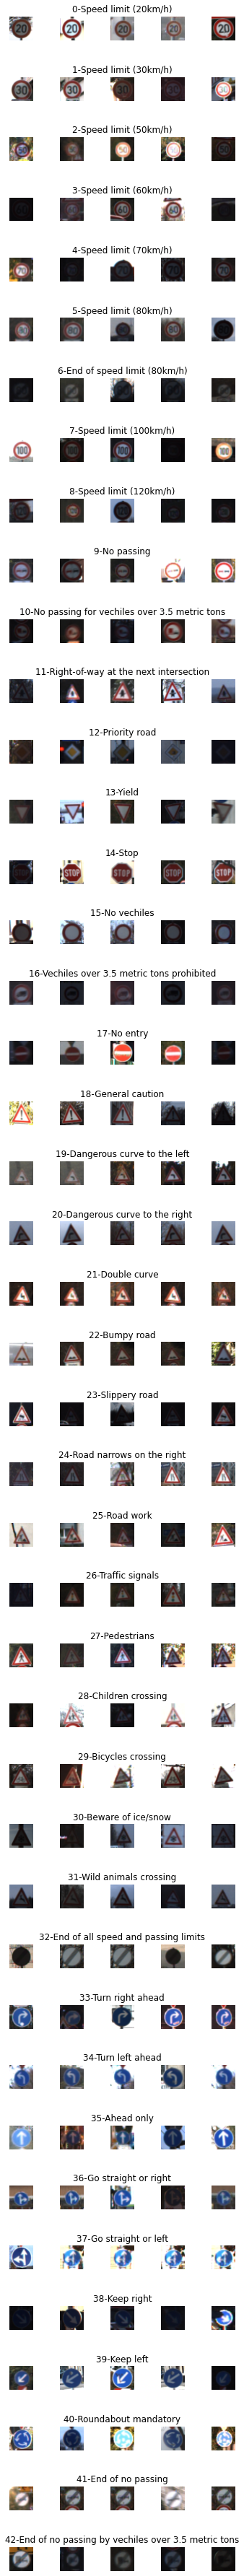

In [ ]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
#print(data)

num_of_samples=[]

cols =5
num_classes=43
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
  for j, row in data.iterrows():
    x_selected = X_train[y_train == j]
    axs[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :], cmap=plt.get_cmap('gray'))
    axs[j][i].axis("off")
    if i == 2:
      axs[j][i].set_title(str(j) + "-" + row["SignName"])
      num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


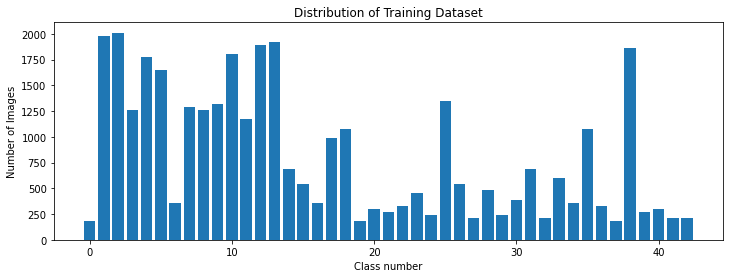

In [ ]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of Training Dataset")
plt.xlabel("Class number")
plt.ylabel("Number of Images")
plt.show()

(32, 32, 3)
36


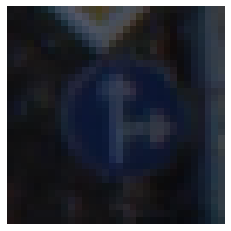

In [ ]:
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


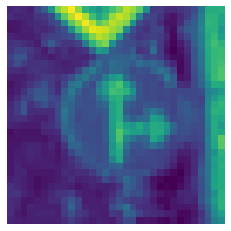

In [ ]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)

(32, 32)


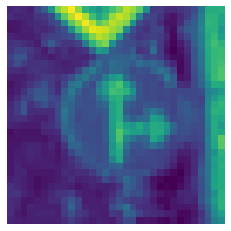

In [ ]:
def equalize(img):
  cv2.equalizeHist(img) #They accept only grayscale images not depth images
  return img

img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [ ]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img

X_train = np.array(list(map(preprocessing, X_train)))
X_valid = np.array(list(map(preprocessing, X_valid)))
X_test = np.array(list(map(preprocessing, X_test)))

(34799, 32, 32)


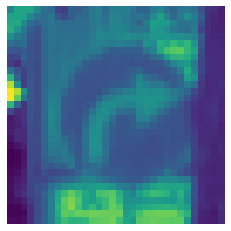

In [ ]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis("off")
print(X_train.shape)

In [ ]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_valid = X_valid.reshape(4410, 32, 32, 1)


In [ ]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10.)

datagen.fit(X_train)

(20, 32, 32, 1)


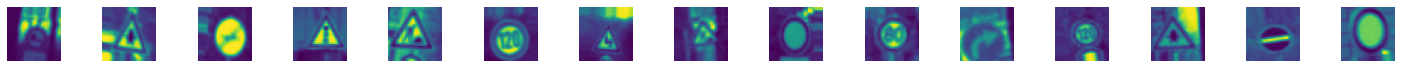

In [ ]:
batches = datagen.flow(X_train, y_train, batch_size=20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20,5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32, 32))
  axs[i].axis("off")

print(X_batch.shape)

In [ ]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [ ]:
y_train = to_categorical(y_train, 43)
y_valid = to_categorical(y_valid, 43)
y_test = to_categorical(y_test, 43)

In [ ]:
def leNet_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  #model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  # Compile Model
  model.compile(Adam(lr=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model

In [ ]:
model = leNet_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 480)              

In [ ]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50), steps_per_epoch=695, epochs=10, validation_data=(X_valid, y_valid), shuffle=1)

Epoch 1/10
695/695 [==============================] - 13s 18ms/step - loss: 0.6632 - accuracy: 0.7977 - val_loss: 0.2031 - val_accuracy: 0.9286
Epoch 2/10
695/695 [==============================] - 12s 18ms/step - loss: 0.3740 - accuracy: 0.8858 - val_loss: 0.1244 - val_accuracy: 0.9596
Epoch 3/10
695/695 [==============================] - 12s 17ms/step - loss: 0.2727 - accuracy: 0.9171 - val_loss: 0.1189 - val_accuracy: 0.9667
Epoch 4/10
695/695 [==============================] - 12s 18ms/step - loss: 0.2190 - accuracy: 0.9327 - val_loss: 0.1580 - val_accuracy: 0.9615
Epoch 5/10
695/695 [==============================] - 12s 17ms/step - loss: 0.1783 - accuracy: 0.9460 - val_loss: 0.0656 - val_accuracy: 0.9800
Epoch 6/10
695/695 [==============================] - 12s 18ms/step - loss: 0.1529 - accuracy: 0.9538 - val_loss: 0.1121 - val_accuracy: 0.9741
Epoch 7/10
695/695 [==============================] - 12s 17ms/step - loss: 0.1358 - accuracy: 0.9597 - val_loss: 0.1172 - val_accuracy:

Text(0.5, 0, 'epoch')

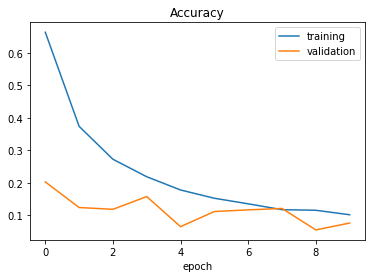

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

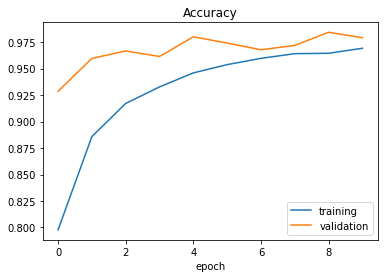

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [ ]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test Score', score[0])
print('Test Accuracy', score[1])

Test Score 0.13454990088939667
Test Accuracy 0.9698337316513062


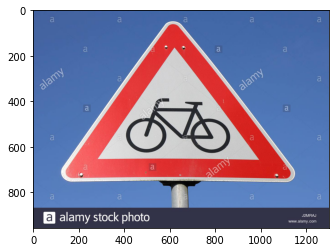

In [ ]:
url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


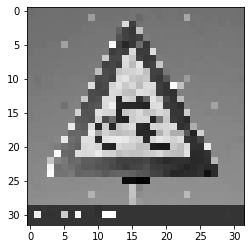

In [ ]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [ ]:
img = img.reshape(1, 32, 32, 1)

In [ ]:
print("predicted sign: "+ str(model.predict_classes(img)))

predicted sign: [25]
